In [1]:
!pip install --upgrade pip
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install qiskit

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install qiskit-aer

Defaulting to user installation because normal site-packages is not writeable


In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit_ibm_runtime import QiskitRuntimeService

In [5]:
from sklearn import datasets, model_selection
iris = datasets.load_iris()

In [6]:
X = iris.data[0:100]
Y = iris.target[0:100]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,Y,test_size=0.33,random_state=42)


In [7]:
!pip install pylatexenc

Defaulting to user installation because normal site-packages is not writeable


In [8]:
print(X_train[0])

[5.2 3.4 1.4 0.2]


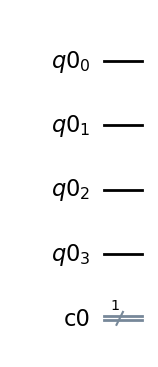

In [9]:
N=4
q = QuantumRegister(N)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

qc.draw("mpl")

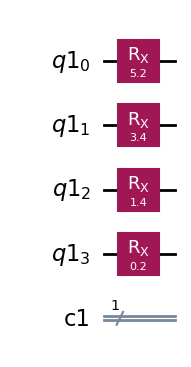

In [10]:
N=4
q = QuantumRegister(N)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

for i, x in enumerate(X_train[0]):
    qc.rx(x, i)

qc.draw("mpl")


In [11]:
N=4
def feature_map(X):

    q = QuantumRegister(N)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)

    for i, x in enumerate(X):
        qc.rx(x, i)
    return qc, c 

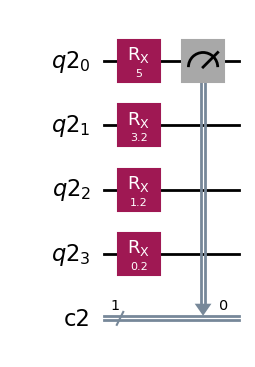

In [12]:
qc, c =feature_map(X_train[5])


# measurement operator
qc.measure(0,c)

qc.draw("mpl")


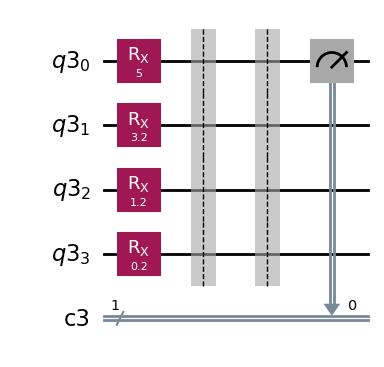

In [13]:
qc, c =feature_map(X_train[5])

qc.barrier()

qc.barrier()

# measurement operator
qc.measure(0,c)

qc.draw("mpl")


In [14]:
##validation circuit

In [15]:
def variational_circuit(qc, theta):
      for i in range(N-1):
            qc.cnot(i,i+1)
      qc.cnot(N-1, 0)
      for i in range(N):
            qc.ry(theta[i], i)
      return qc


In [16]:
def variational_circuit(qc, theta):
    for i in range(N - 1):
        qc.cx(i, i + 1)     # ← 修正ポイント！
    qc.cx(N - 1, 0)
    for i in range(N):
        qc.ry(theta[i], i)
    return qc


{'00': 4999, '11': 5001}
P(11) = 0.5001


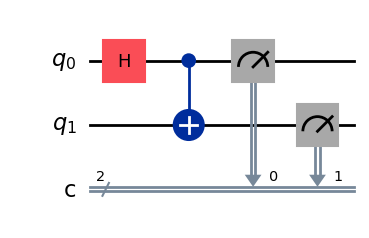

In [17]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer

shots = 10_000

qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])

backend = Aer.get_backend("qasm_simulator")
job = backend.run(qc, shots=shots)
result = job.result()
counts = result.get_counts()

print(counts)

# 「両方1」の確率
p_11 = counts.get("11", 0) / shots
print("P(11) =", p_11)

qc.draw("mpl")


In [18]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer

def quantum_nn(X, theta, simulator="qasm_simulator"):
    """量子ニューラルネットワーク（Qiskit v2対応版）"""
    N = len(theta)
    
    # 回路の定義
    qc = QuantumCircuit(N, N)
    for i in range(N):
        qc.ry(X[i], i)
    for i in range(N - 1):
        qc.cx(i, i + 1)
    for i in range(N):
        qc.ry(theta[i], i)
    qc.measure(range(N), range(N))
    
    # バックエンドと実行
    backend = Aer.get_backend(simulator)
    shots = 10_000
    job = backend.run(qc, shots=shots)  # ← qiskit.execute の代わり
    result = job.result()
    counts = result.get_counts()
    
    # 出力確率の例（全ビットが1の確率）
    p_ones = counts.get("1" * N, 0) / shots
    return p_ones


In [19]:
import numpy as np

#X_train = np.random.rand(10, 3)  # 仮の入力
#N = 3

prediction = quantum_nn(X_train[5], np.random.rand(N))
print("Prediction =", prediction)


Prediction = 0.0307


In [20]:
target = Y_train[5]
target

0

In [21]:
(target - prediction)**2

0.0009424900000000001

In [22]:
def loss(prediction, target):
      return (target - prediction)**2


In [23]:
loss(prediction, target)

0.0009424900000000001

In [24]:
import copy

def gradient(X, Y, theta):
    
      delta = 0.01

      grad = []
    
      for i in range(len(theta)):

          dtheta = copy.copy(theta)
          dtheta[i] += delta

          pred1 = quantum_nn(X, dtheta)
          pred2 = quantum_nn(X, theta)
          # finite difference
          grad.append( (loss(pred1, Y)-loss(pred2, Y))/ delta)

      return np.array(grad)

In [25]:
def accuracy(X, Y, theta):

      counter = 0
      for X_i, Y_i in zip(X, Y):

          prediction = quantum_nn(X_i, theta)

          if prediction < 0.5 and Y_i == 0:
               counter +=1
          elif prediction >= 0.5 and Y_i == 1:
               counter +=1
      return counter/len(Y)

In [26]:
eta = 0.05 

loss_list = []
theta = np.ones(N)

print("Epoch \t Loss \t Tranining Accuracy")

# training epoch 
for i in range(20):

    loss_tmp = []

    for X_i, Y_i in zip(X_train, Y_train):

        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss(prediction, Y_i))

        # update theta,gradient descent rule
        theta = theta - eta * gradient(X_i, Y_i, theta)
    
    loss_list.append(np.mean(loss_tmp))
    acc = accuracy(X_train, Y_train, theta)
    print(f"{i} \t {loss_list[-1]:.3f} \t {acc:.3f}")

Epoch 	 Loss 	 Tranining Accuracy
0 	 0.533 	 0.463
1 	 0.532 	 0.463
2 	 0.527 	 0.463
3 	 0.523 	 0.463
4 	 0.518 	 0.463
5 	 0.514 	 0.463
6 	 0.499 	 0.463
7 	 0.470 	 0.463
8 	 0.344 	 0.672
9 	 0.189 	 0.776
10 	 0.135 	 0.866
11 	 0.091 	 0.910
12 	 0.060 	 0.940
13 	 0.044 	 0.940
14 	 0.034 	 0.940
15 	 0.032 	 0.940
16 	 0.031 	 0.940
17 	 0.033 	 0.955
18 	 0.033 	 0.940
19 	 0.033 	 0.970


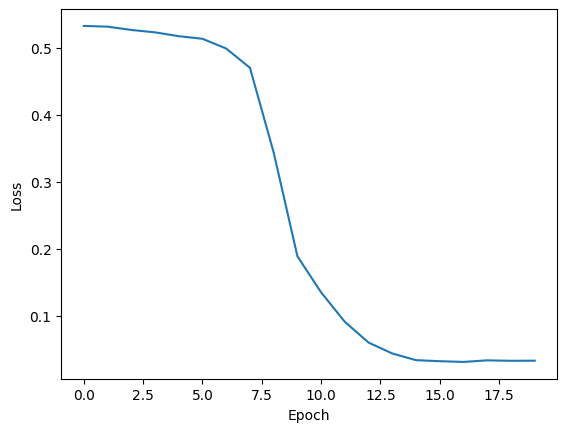

In [27]:
import matplotlib.pyplot as plt

plt.plot(loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [28]:
accuracy(X_test, Y_test, theta)

1.0